# MSM-MCMC

## Method of Simulated Moments using Markov Chain Monte Carlo

If you are a new user of the package MSM.jl, see [this notebook](https://github.com/JulienPascal/MSM.jl/tree/main/notebooks) first. 

In this notebook, we use the **Laplace Type Estimator** formulation of GMM by [Chernozhukov and Hong (2003)](https://www.sciencedirect.com/science/article/abs/pii/S0304407603001003) in the context of the Method of Simulated Moments.

In a nuthsell, we transform the problem of maximizing the MSM objective function into the problem of maximizing a **quasi-posterior**. Hence **Markov Chain Monte Carlo** (or posterior simulation methods) can be used.

I use [AffineInvariantMCMC](https://github.com/madsjulia/AffineInvariantMCMC.jl) because it can run the MCMC algorithm in parallel on a cluster.

---

The notebook does not run correctly? run the file [LTE.jl](https://github.com/JulienPascal/MSM.jl/blob/main/notebooks/LTE.jl) directly

```bash
julia LTE.jl
```

---

In [1]:
using ClusterManagers
using Distributed

OnCluster = false #set to false to run locally
addWorkers = false #set to false to run serially
println("OnCluster = $(OnCluster)")

# Current number of workers
#--------------------------
currentWorkers = nworkers()
println("Initial number of workers = $(currentWorkers)")

# Increase the number of workers available
#-----------------------------------------
maxNumberWorkers = 1#10
if addWorkers == true
	if OnCluster == true
	  addprocs(SlurmManager(maxNumberWorkers))
	else
	  addprocs(maxNumberWorkers)
	end
end


# Sanity checks
#-------------
hosts = []
pids = []
for i in workers()
	host, pid = fetch(@spawnat i (gethostname(), getpid()))
	println("Hello I am worker $(i), my host is $(host)")
	push!(hosts, host)
	push!(pids, pid)
end

currentWorkers = nworkers()
println("Number of workers = $(currentWorkers)")

OnCluster = false
Initial number of workers = 1
Hello I am worker 1, my host is julien-myPC
Number of workers = 1


In [2]:
using Plots
using ParallelDataTransfer
using DataFrames
using RobustPmap #Necessary for AffineInvariantMCMC
using CSV
@everywhere using MSM
@everywhere using DataStructures
@everywhere using OrderedCollections
@everywhere using Distributions
@everywhere using Random
@everywhere using DataStructures
@everywhere using Statistics
@everywhere using LinearAlgebra
@everywhere using AffineInvariantMCMC
@everywhere using LinearAlgebra

In [3]:
# Generate simulated data
Random.seed!(1234)  #for replicability reasons
T = 10000          #number of periods
P = 2               #number of dependent variables

#beta0 = rand(P)     #choose true coefficients by drawing from a uniform distribution on [0,1]
#alpha0 = rand(1)[]  #intercept

theta0 = 0.0        #coefficient to create serial correlation in the error terms
beta0 = rand(P)
alpha0 = rand(1)[] 

println("True intercept = $(alpha0)")
println("True coefficient beta0 = $(beta0)")
println("Serial correlation coefficient theta0 = $(theta0)")
true_vals = [alpha0, beta0[1], beta0[2]]

# Generation of error terms
# row = individual dimension
# column = time dimension 
U = zeros(T)
d = Normal()
U[1] = rand(d, 1)[] #first error term
# loop over time periods
for t = 2:T
    U[t] = rand(d, 1)[] + theta0*U[t-1]
end

# Let's simulate the dependent variables x_t
x = zeros(T, P)

d = Uniform(0, 5)
for p = 1:P  
    x[:,p] = rand(d, T)
end

# Let's calculate the resulting y_t
y = zeros(T)

for t=1:T
    y[t] = alpha0 + x[t,1]*beta0[1] + x[t,2]*beta0[2] + U[t]
end

# Send simulated data to workers
sendto(workers(), y=y)
sendto(workers(), x=x)

True intercept = 0.5662374165061859
True coefficient beta0 = [0.5908446386657102, 0.7667970365022592]
Serial correlation coefficient theta0 = 0.0


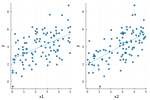

In [4]:
# Visualize data
p1 = scatter(x[1:100,1], y[1:100], xlabel = "x1", ylabel = "y", legend=:none, smooth=true)
p2 = scatter(x[1:100,2], y[1:100], xlabel = "x2", ylabel = "y", legend=:none, smooth=true)
plot(p1, p2)

In [5]:
# Define locally
myProblem = MSMProblem(options = MSMOptions(maxFuncEvals=1000, globalOptimizer = :dxnes, localOptimizer = :NelderMead));

# Send to workers
sendto(workers(), myProblem=myProblem)

In [6]:
# Priors
dictPriors = OrderedDict{String,Array{Float64,1}}()
dictPriors["alpha"] = [0.5, 0.001, 1.0]
dictPriors["beta1"] = [0.5, 0.001, 1.0]
dictPriors["beta2"] = [0.5, 0.001, 1.0]

# Empirical moments
dictEmpiricalMoments = OrderedDict{String,Array{Float64,1}}()
dictEmpiricalMoments["mean"] = [mean(y)] #informative on the intercept
dictEmpiricalMoments["mean^2"] = [mean(y.^2)] #informative on the intercept
dictEmpiricalMoments["mean_x1y"] = [mean(x[:,1] .* y)] #informative on betas
dictEmpiricalMoments["mean_x2y"] = [mean(x[:,2] .* y)] #informative on betas
dictEmpiricalMoments["mean_x1y^2"] = [mean((x[:,1] .* y).^2)] #informative on betas
dictEmpiricalMoments["mean_x2y^2"] = [mean((x[:,2] .* y).^2)] #informative on betas

W = Matrix(1.0 .* I(length(dictEmpiricalMoments)))#initialization
#Special case: diagonal matrix
#Sum of square percentage deviations from empirical moments
#(you may choose something else)
for (indexMoment, k) in enumerate(keys(dictEmpiricalMoments))
    W[indexMoment,indexMoment] = 1.0/(dictEmpiricalMoments[k][1])^2
end

# Send to workers
sendto(workers(), dictPriors=dictPriors)
sendto(workers(), dictEmpiricalMoments=dictEmpiricalMoments)
sendto(workers(), W=W)

In [7]:
@everywhere set_priors!(myProblem, dictPriors)
@everywhere set_empirical_moments!(myProblem, dictEmpiricalMoments)
@everywhere set_weight_matrix!(myProblem, W)

In [8]:
# x[1] corresponds to the intercept, x[2] corresponds to beta1, x[3] corresponds to beta2
@everywhere function functionLinearModel(x; uniform_draws::Array{Float64,1}, simX::Array{Float64,2}, nbDraws::Int64 = length(uniform_draws), burnInPerc::Int64 = 0)
    T = nbDraws
    P = 2       #number of dependent variables

    alpha = x[1]
    beta = x[2:end]
    theta = 0.0     #coefficient to create serial correlation in the error terms

    # Creation of error terms
    # row = individual dimension
    # column = time dimension
    U = zeros(T)
    d = Normal()
    # Inverse cdf (i.e. quantile)
    gaussian_draws = quantile.(d, uniform_draws)
    U[1] = gaussian_draws[1] #first error term

    # loop over time periods
    for t = 2:T
        U[t] = gaussian_draws[t] + theta*U[t-1]
    end

    # Let's calculate the resulting y_t
    y = zeros(T)

    for t=1:T
        y[t] = alpha + simX[t,1]*beta[1] + simX[t,2]*beta[2] + U[t]
    end

    # Get rid of the burn-in phase:
    #------------------------------
    startT = max(1, Int(nbDraws * (burnInPerc / 100)))

    # Moments:
    #---------
    output = OrderedDict{String,Float64}()
    output["mean"] = mean(y[startT:nbDraws])
    output["mean^2"] = mean(y[startT:nbDraws].^2)
    output["mean_x1y"] = mean(simX[startT:nbDraws,1] .* y[startT:nbDraws])
    output["mean_x2y"] = mean(simX[startT:nbDraws,2] .* y[startT:nbDraws])
    output["mean_x1y^2"] = mean((simX[startT:nbDraws,1] .* y[startT:nbDraws]).^2)
    output["mean_x2y^2"] = mean((simX[startT:nbDraws,2] .* y[startT:nbDraws]).^2)

    return output
end


In [9]:
# Let's freeze the randomness during the minimization
d_Uni = Uniform(0,1)
nbDraws = T #Number of draws in the simulated data
burnInPerc = 0 #Burn-in phase. Not necessary in the present context.
startT = startT = max(1, Int(nbDraws * (burnInPerc / 100))) #First period used to calculate moments on simulated data
NMSM = nbDraws - startT + 1; #Number of Draws used when calculated moments on simulated data
uniform_draws = rand(d_Uni, nbDraws)
simX = zeros(length(uniform_draws), 2)
d = Uniform(0, 5)
for p = 1:2
  simX[:,p] = rand(d, length(uniform_draws))
end

# Send to workers
sendto(workers(), burnInPerc=burnInPerc)
sendto(workers(), simX=simX)
sendto(workers(), uniform_draws=uniform_draws)

# Construct the objective function everywhere
@everywhere set_simulate_empirical_moments!(myProblem, x -> functionLinearModel(x, uniform_draws = uniform_draws, simX = simX, burnInPerc=burnInPerc))
@everywhere construct_objective_function!(myProblem)

In [10]:
# Safety check: value on the master node == values on slave nodes?
using Test
val_local = myProblem.objective_function(ones(3)); #local execution
val_workers = [];
for w in workers() #Execution on workers
    push!(val_workers, @fetchfrom w myProblem.objective_function(ones(3)))
end
for (wIndex, w) in enumerate(workers())
    @test abs(val_local - val_workers[wIndex]) < 10e-10
end

### Markov Chain Monte Carlo

#### Tuning Paramaters

In [11]:
#------------------------------------------------------------------------------
# Formulate the problem as a Laplace Type Estimator and use MCMC to find
# the quasi-posterior median
#------------------------------------------------------------------------------
# For tuning parameters, see: See https://github.com/madsjulia/AffineInvariantMCMC.jl
@everywhere begin
	numdims = 3
	numwalkers = 10
	thinning = 10
	numsamples_perwalker = 10000
	burnin = Int((1/10)*numsamples_perwalker)
	lb = 0 .* ones(numdims) #lower bound
	ub = 1 .* ones(numdims) #upper bound
	# Uniform prior
	# d_prior = Product(Uniform.(lb, ub))
	# Normal
	d_prior = MvNormal(zeros(numdims), 1.0 .* I(numdims))
end

# Pseudo Log-likelihood
@everywhere function Ln_MSM(x, NMSM)
	return -0.5*NMSM*myProblem.objective_function(x)
end

# Pseudo Log quasi-posterior: Pseudo Log(likelihood) + log(prior)
@everywhere function quasi_posterior(x, NMSM, d_prior)
    return Ln_MSM(x, NMSM) + log(pdf(d_prior, x))
end


# Safety check: value on the master node == values on slave nodes?
using Test
val_local = Ln_MSM(ones(3), NMSM); #local execution
val_workers = [];
for w in workers() #Execution on workers
    push!(val_workers, @fetchfrom w Ln_MSM(ones(3), NMSM))
end
for (wIndex, w) in enumerate(workers())
    @test abs(val_local - val_workers[wIndex]) < 10e-10
end

#### MCMC

See [AffineInvariantMCMC.jl](https://github.com/madsjulia/AffineInvariantMCMC.jl)

In [12]:
# Slightly perturb the initial draws for the walkers
x0 = [dictPriors[k][1] for k in keys(dictPriors)]
x0_chains = ones(numdims, numwalkers).*true_vals .+ rand(numdims, numwalkers) .* 1.0
chain, llhoodvals = AffineInvariantMCMC.sample(x -> quasi_posterior(x, nbDraws, d_prior), numwalkers, x0_chains, burnin, 1)
chain, llhoodvals = AffineInvariantMCMC.sample(x -> quasi_posterior(x, nbDraws, d_prior), numwalkers, chain[:, :, end], numsamples_perwalker, thinning)
flatchain, flatllhoodvals = AffineInvariantMCMC.flattenmcmcarray(chain, llhoodvals)

([0.8322244814045684 0.8663377715081676 … 0.7536635669027645 0.6236616143406905; 0.5159769953547604 0.533298756562614 … 0.5603355210604782 0.5784702591258903; 0.7447930693003086 0.7267281778395929 … 0.7335001571680391 0.7588499301637062], [-5.93454162050324, -5.965889143653129, -6.232348313286927, -3.8263540788019226, -4.65106120775652, -5.041414457817079, -4.015582082771398, -5.474494685302703, -4.959653184921691, -5.052378970394658  …  -5.481259383394306, -4.11619512387114, -8.833321549342745, -5.728961790322405, -4.651592648943476, -6.291617920860309, -6.156151429077656, -3.931895340577719, -4.2759125614556375, -4.4148307306478225])

#### Results

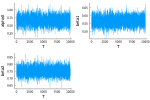

In [13]:
#-------------------------------------------------------------------------------
# Plot Draws
#-------------------------------------------------------------------------------
p1 = plot(flatchain[1,:], ylabel="alpha0", xlabel="T", legend=:none)
p2 = plot(flatchain[2,:], ylabel="beta1", xlabel="T", legend=:none)
p3 = plot(flatchain[3,:], ylabel="beta2", xlabel="T", legend=:none)
p4 = plot(p1, p2, p3)
savefig(p4, joinpath(pwd(),"chains_MSM_MCMC.png"))
display(p4)

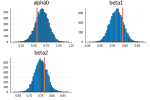

In [14]:
hh1 = histogram(flatchain[1,burnin:end], title="alpha0", legend=:none)
vline!(hh1, [alpha0[1]], linewidth = 4)
hh2 = histogram(flatchain[2,burnin:end], title="beta1", legend=:none)
vline!(hh2, [beta0[1]], linewidth = 4)
hh3 = histogram(flatchain[3,burnin:end], title="beta2", legend=:none)
vline!(hh3, [beta0[2]], linewidth = 4)
hh4 = plot(hh1, hh2, hh3)
display(hh4)
savefig(hh4, joinpath(pwd(),"histograms_MSM_MCMC.png"))

In [15]:
# Compare results with GLM
using DataFrames, GLM
data = DataFrame(x1=x[:,1], x2=x[:,2], y= y[:]);
ols = lm(@formula(y ~ x1 + x2), data)
coef_ols = coef(ols)
ci_ols = confint(ols)
stderror_ols = stderror(ols)

result_alpha0 = append!(quantile(flatchain[1,burnin:end],[0.05, 0.10, 0.5, 0.90, 0.95]), std(flatchain[1,burnin:end]), NaN, alpha0[1],NaN, coef_ols[1], ci_ols[1,1], ci_ols[1,2], stderror_ols[1])
result_beta1 = append!(quantile(flatchain[2,burnin:end],[0.05, 0.10, 0.5, 0.90, 0.95]), std(flatchain[2,burnin:end]), NaN,beta0[1], NaN,coef_ols[2], ci_ols[2,1], ci_ols[2,2], stderror_ols[2])
result_beta2 = append!(quantile(flatchain[3,burnin:end],[0.05, 0.10, 0.5, 0.90, 0.95]), std(flatchain[3,burnin:end]), NaN,beta0[2], NaN,coef_ols[3], ci_ols[3,1], ci_ols[3,2], stderror_ols[3])
results = DataFrame(variable = ["P5"; "P10"; "Median"; "P90"; "P95"; "std"; "-" ;"True value"; "-" ;"OLS Estimate"; "P5 OLS"; "P95 OLS"; "Std OLS"],
						alpha0 = result_alpha0, beta1 = result_beta1, beta2 = result_beta2)

CSV.write(joinpath(pwd(),"output_table_MSM_MCMC.csv"), results)
results

,variable,alpha0,beta1,beta2
,String,Float64,Float64,Float64
1,P5,0.447918,0.522994,0.707646
2,P10,0.501359,0.532195,0.717394
3,Median,0.668242,0.566473,0.751272
4,P90,0.836027,0.600178,0.785959
5,P95,0.882373,0.609984,0.795051
6,std,0.130992,0.0263574,0.0269995
7,-,NaN,NaN,NaN
8,True value,0.566237,0.590845,0.766797
9,-,NaN,NaN,NaN


### Efficient W Matrix

In [16]:
#------------------------------------------------------------------------------
# Formulate the problem as a Laplace Type Estimator and use MCMC to find
# the quasi-posterior median
#------------------------------------------------------------------------------
# For tuning parameters, see: See https://github.com/madsjulia/AffineInvariantMCMC.jl
@everywhere begin
	numdims = 3
	numwalkers = 10
	thinning = 10
	numsamples_perwalker = 10000
	burnin = Int((1/10)*numsamples_perwalker)
	lb = 0 .* ones(numdims) #lower bound
	ub = 1 .* ones(numdims) #upper bound
	# Uniform prior
	# d_prior = Product(Uniform.(lb, ub))
	# Normal
	d_prior = MvNormal(zeros(numdims), 1.0 .* I(numdims))
end

# Pseudo Log-likelihood
@everywhere function Ln_MSM(x, NMSM)
	return -0.5*NMSM*myProblem.objective_function(x)
end

# Pseudo Log quasi-posterior: Pseudo Log(likelihood) + log(prior)
@everywhere function quasi_posterior(x, NMSM, d_prior)
    return Ln_MSM(x, NMSM) + log(pdf(d_prior, x))
end


# Safety check: value on the master node == values on slave nodes?
using Test
val_local = Ln_MSM(ones(3), NMSM); #local execution
val_workers = [];
for w in workers() #Execution on workers
    push!(val_workers, @fetchfrom w Ln_MSM(ones(3), NMSM))
end
for (wIndex, w) in enumerate(workers())
    @test abs(val_local - val_workers[wIndex]) < 10e-10
end

In [17]:
#-------------------------------------------------------------------------------
# Efficient MSM
#-------------------------------------------------------------------------------
# Set the W = inverse(Distance Matrix)
# Distance Matrix using Empirical Series
#---------------------------------------
X = zeros(T, 6)
X[:,1] = y
X[:,2] = y.^2
X[:,3] = (x[:,1] .* y)
X[:,4] = (x[:,2] .* y)
X[:,5] = (x[:,1] .* y).^2
X[:,6] = (x[:,2] .* y).^2
Sigma0 = cov(X)
W_efficient = inv(Sigma0)

6×6 Matrix{Float64}:
 11.6827     -1.38829     -0.766429     …   0.0255655     0.0293685
 -1.38829     0.21793      0.0613953       -0.00334536   -0.00385388
 -0.766429    0.0613953    0.197381        -0.00554023   -0.000273849
 -0.887788    0.0685391    0.033405        -0.00027403   -0.00577113
  0.0255655  -0.00334536  -0.00554023       0.000202925   8.36822e-6
  0.0293685  -0.00385388  -0.000273849  …   8.36822e-6    0.000210529

In [18]:
@everywhere set_weight_matrix!(myProblem, W_efficient)
@everywhere construct_objective_function!(myProblem)

# Safety check: value on the master node == values on slave nodes?
using Test
val_local = myProblem.objective_function(ones(3)); #local execution
val_workers = [];
for w in workers() #Execution on workers
    push!(val_workers, @fetchfrom w myProblem.objective_function(ones(3)))
end
for (wIndex, w) in enumerate(workers())
    @test abs(val_local - val_workers[wIndex]) < 10e-10
end

#Slightly perturb the initial draws for the walkers
x0 = [dictPriors[k][1] for k in keys(dictPriors)]
x0_chains = ones(numdims, numwalkers).*true_vals .+ rand(numdims, numwalkers) .* 1.0
chain, llhoodvals = AffineInvariantMCMC.sample(x -> quasi_posterior(x, nbDraws, d_prior), numwalkers, x0_chains, burnin, 1)
chain, llhoodvals = AffineInvariantMCMC.sample(x -> quasi_posterior(x, nbDraws, d_prior), numwalkers, chain[:, :, end], numsamples_perwalker, thinning)
flatchain, flatllhoodvals = AffineInvariantMCMC.flattenmcmcarray(chain, llhoodvals)


([0.5968198662384236 0.5842247642376026 … 0.6001734426181857 0.5646930870476905; 0.6055058775323404 0.5831707446279086 … 0.5622823219113214 0.5913189364248616; 0.7472357312062459 0.7720412879680396 … 0.7863088264507345 0.7757112355635092], [-6.929606915995947, -6.1369091791853965, -6.761902312469809, -7.593682274100264, -7.292386041224399, -6.582689774079618, -5.79879646810344, -5.657631332724222, -6.571017304817464, -5.830150289080295  …  -6.350991179257283, -5.679156630039426, -5.735675439688668, -9.755887640865158, -11.612758775534067, -7.377967751619911, -6.935451852214069, -6.180400098602873, -7.254263146542687, -5.840958922894032])

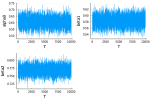

In [19]:
#-------------------------------------------------------------------------------
# Plot Draws
#-------------------------------------------------------------------------------
p1 = plot(flatchain[1,:], ylabel="alpha0", xlabel="T", legend=:none)
p2 = plot(flatchain[2,:], ylabel="beta1", xlabel="T", legend=:none)
p3 = plot(flatchain[3,:], ylabel="beta2", xlabel="T", legend=:none)
p4 = plot(p1, p2, p3)

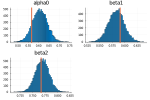

In [20]:
hh1 = histogram(flatchain[1,burnin:end], title="alpha0", legend=:none)
vline!(hh1, [alpha0[1]], linewidth = 4)
hh2 = histogram(flatchain[2,burnin:end], title="beta1", legend=:none)
vline!(hh2, [beta0[1]], linewidth = 4)
hh3 = histogram(flatchain[3,burnin:end], title="beta2", legend=:none)
vline!(hh3, [beta0[2]], linewidth = 4)
hh4 = plot(hh1, hh2, hh3)

In [21]:
# Compare results with GLM
using DataFrames, GLM
data = DataFrame(x1=x[:,1], x2=x[:,2], y= y[:]);
ols = lm(@formula(y ~ x1 + x2), data)
coef_ols = coef(ols)
ci_ols = confint(ols)
stderror_ols = stderror(ols)

result_alpha0 = append!(quantile(flatchain[1,burnin:end],[0.05, 0.10, 0.5, 0.90, 0.95]), std(flatchain[1,burnin:end]), NaN, alpha0[1],NaN, coef_ols[1], ci_ols[1,1], ci_ols[1,2], stderror_ols[1])
result_beta1 = append!(quantile(flatchain[2,burnin:end],[0.05, 0.10, 0.5, 0.90, 0.95]), std(flatchain[2,burnin:end]), NaN,beta0[1], NaN,coef_ols[2], ci_ols[2,1], ci_ols[2,2], stderror_ols[2])
result_beta2 = append!(quantile(flatchain[3,burnin:end],[0.05, 0.10, 0.5, 0.90, 0.95]), std(flatchain[3,burnin:end]), NaN,beta0[2], NaN,coef_ols[3], ci_ols[3,1], ci_ols[3,2], stderror_ols[3])
results_efficient = DataFrame(variable = ["P5"; "P10"; "Median"; "P90"; "P95"; "std"; "-" ;"True value"; "-" ;"OLS Estimate"; "P5 OLS"; "P95 OLS"; "Std OLS"],
					   alpha0 = result_alpha0, beta1 = result_beta1, beta2 = result_beta2)

CSV.write(joinpath(pwd(),"output_table_MSM_MCMC_efficient.csv"), results_efficient)
results_efficient

,variable,alpha0,beta1,beta2
,String,Float64,Float64,Float64
1,P5,0.546721,0.557092,0.746771
2,P10,0.56005,0.563103,0.751709
3,Median,0.60575,0.583449,0.76912
4,P90,0.651271,0.602986,0.786237
5,P95,0.663911,0.60924,0.790942
6,std,0.0358015,0.0156563,0.0134606
7,-,NaN,NaN,NaN
8,True value,0.566237,0.590845,0.766797
9,-,NaN,NaN,NaN


## Appendix

In [22]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
